### ESN application: El-Nino Southern Oscillation (ENSO)

Following https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni and using the NINO3.4 box, we can diagnose the El-Nino-Southern-Oscillation Index (ENSO) from sea-surface temperature (SST). 

SST data: https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc

Data contains **monthly mean SST** from 1854 .. 2021, in a 2° by 2° lat/lon grid:  
**lat:** 88N .. -88N (= 88S)  
**lon:** 0E .. 358E

Start from 1880, as in [Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002) paper "Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability".

**Outline**

- Calculate ENSO index
- Predict events (El Nino / La Nina / neutral) from ENSO index
- Optimize baseESN, try DeepESN and other ANN architectures for comparison

### Tech preamble

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate
import tensorflow.keras.initializers as tfi
from tensorflow.keras.utils import plot_model

# Work with my own library of useful ESN functions
from ESN_functions_v03 import *

### Load SST data

In [2]:
# Use, when working with relative path on local machine (or nesh)
sst_path = "../data/sst.mnmean.nc"
sst_dataset = xr.open_dataset(sst_path)
sst_dataset

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2015, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-11-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-12-06

### Calculating ENSO index from sst data

There are several indices used to monitor the tropical Pacific, all of which are based on SST anomalies averaged across a given region.  Usually the anomalies are computed relative to a base period of 30 years.  The Niño 3.4 index is one of the most commonly used indices to define El Niño and La Niña events.

Website https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni gives introduction to ENSO indices. Paper [Morrow et al., 2010] shows index for Niño 3.4 region (5°N–5°S, 120–170°W) in the tropical Pacific. The website references a link to an "expert guide" with more detailed information and a recipe on calculating ENSO indices:

(...) Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period. (...)

In [3]:
### Compute area averaged total SST from Niño 3.4 region (5°N–5°S, 120–170°W).
# Note: Since the box of interest is close to equator (5°N-5°S) we simply average over the box area and don't take care
# care of area weighting here.
# Note: latitude comes in a grid 88, 86, .., -86, 88, slice(5,-5) is actually using (4°N-4°S) only.
# Note: longitude ranges from 0 to 358°E. Region of interest (120-170°W) translates to (190°E-240°E) here.
sst_mean = sst_dataset.sst.sel(time=slice('1880-01-01', '2021-11-01')).sel(lat=slice(5,-5)).sel(lon=slice(190,240)).mean(("lat", "lon"))

In [4]:
# Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño 3.4 region
sst_climatology = (
    sst_dataset.sst
    .sel(time=slice('1950-01-01','1979-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon", "time"))
)

In [5]:
# Compute std dev in ime for monthly climatology (e.g., 1950-1979), 
# use area averaged total SST from Niño 3.4 region
sst_climatology_std = (
    sst_dataset.sst
    .sel(time=slice('1950-01-01','1979-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .std("time")          
)

In [6]:
# Subtract climatology from area averaged total SST time series to obtain anomalies
sst_anomaly = sst_mean - sst_climatology

In [7]:
# Smooth the anomalies with a 5-month running mean to get ENSO index
ENSO_index = sst_anomaly.rolling(time=5, center=True).mean().dropna("time")

In [8]:
# Recipy for calculating ENSO index requires normalization of the smoothed anomalies
# by its standard deviation over the climatological period.
ENSO_index_norm = ENSO_index / sst_climatology_std

<function matplotlib.pyplot.show(close=None, block=None)>

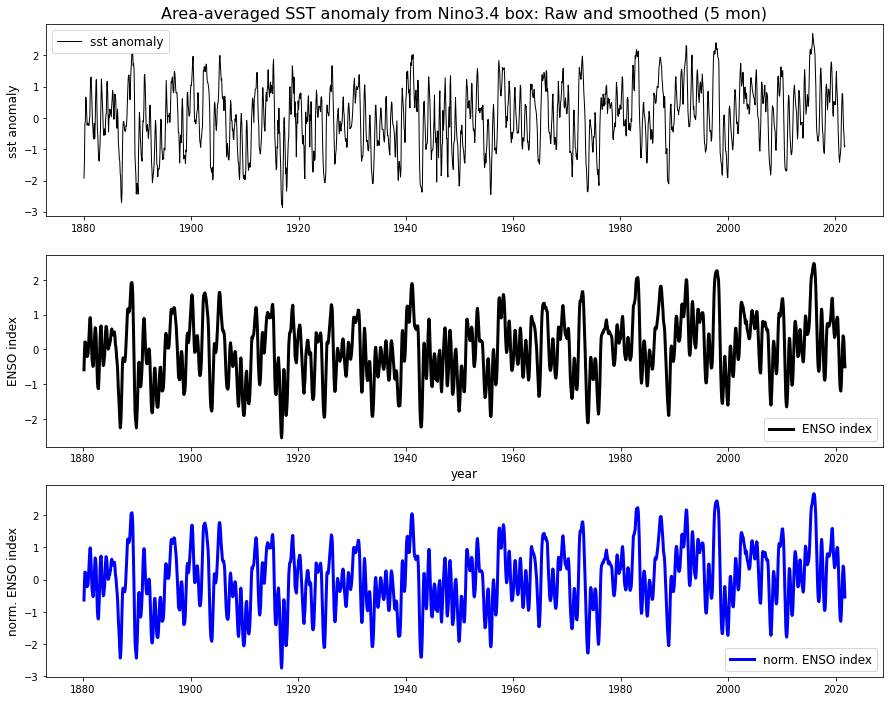

In [9]:
# First glance at raw sst anomaly timeseries and (un-)normalized ENSO index
fig, axes = plt.subplots(3, 1, figsize=(15,12))
axes[0].plot(sst_anomaly.time, sst_anomaly, label='sst anomaly', color='black', linewidth=1)
axes[1].plot(ENSO_index.time, ENSO_index, label='ENSO index', color='black', linewidth=3)
axes[2].plot(ENSO_index_norm.time, ENSO_index_norm, label='norm. ENSO index', color='blue', linewidth=3)
axes[1].set_xlabel("year", fontsize=12)
axes[0].set_ylabel("sst anomaly", fontsize=12)
axes[1].set_ylabel("ENSO index", fontsize=12)
axes[2].set_ylabel("norm. ENSO index", fontsize=12)
axes[0].legend(fontsize=12)
axes[1].legend(fontsize=12)
axes[2].legend(fontsize=12)
axes[0].set_title("Area-averaged SST anomaly from Nino3.4 box: Raw and smoothed (5 mon)", fontsize=16)
plt.show

In [10]:
# Augmented Dickey-Fuller Test on normalized ENSO index: 
# Check, how strong timeseries is determined by possible trend.
ADFT_ENSO = adfuller(ENSO_index_norm)

# Print results from ADFT:
print('\nnorm. ENSO index:')
print('==================')
print('ADF Statistic: %f' % np.round(ADFT_ENSO[0],3))
print('p-value: %f' % np.round(ADFT_ENSO[1],3))


norm. ENSO index:
ADF Statistic: -6.553000
p-value: 0.000000


<function matplotlib.pyplot.show(close=None, block=None)>

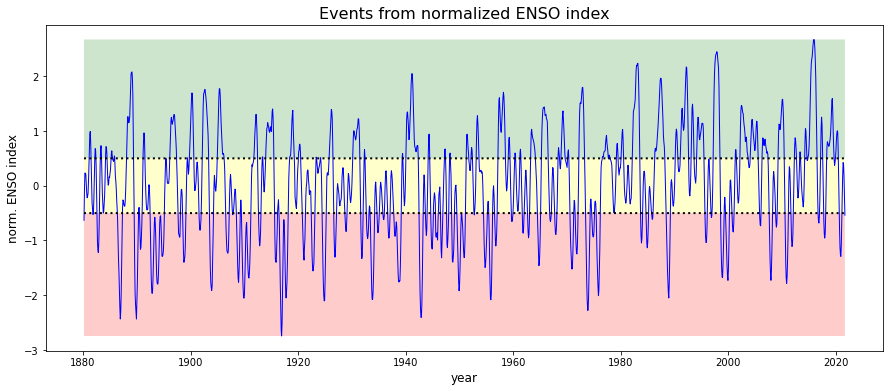

In [11]:
# Get min/max for norm. ENSO index, for plotting shaded areas separating events:
ENSO_min = np.min(ENSO_index_norm)
ENSO_max = np.max(ENSO_index_norm)

# Focus on normalized ENSO index: Highlight events.
# > 0.5: EL Nino, < -0.5: La Nina, else: 'neutral'
fig, axes = plt.subplots(1, 1, figsize=(15,6))
axes.plot(ENSO_index_norm.time, ENSO_index_norm, label='norm. ENSO index', color='blue', linewidth=1)
axes.set_xlabel("year", fontsize=12)
axes.set_ylabel("norm. ENSO index", fontsize=12)
axes.set_title("Events from normalized ENSO index", fontsize=16)

# Add horizontal lines
axes.plot(ENSO_index_norm.time,0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)
axes.plot(ENSO_index_norm.time,-0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)

# Shade area highlighting distinct events.
axes.fill_between(np.array(ENSO_index_norm.time), 0.5, ENSO_max, facecolor='green', alpha=0.2)
axes.fill_between(np.array(ENSO_index_norm.time), -0.5, ENSO_min, facecolor='red', alpha=0.2)
axes.fill_between(np.array(ENSO_index_norm.time), -0.5, 0.5, facecolor='yellow', alpha=0.2)

plt.show

In [12]:
# Get number of events: Absolute and realtive to ALL events
print("\nnormalmized ENSO index")
print("======================")

print("\nTOTAL number of timesteps: ", len(ENSO_index_norm))
print("number of timesteps connected to EL Nino events: ", np.sum(ENSO_index_norm.values>0.5))
print("number of timesteps connected to La Nina events: ", np.sum(ENSO_index_norm.values<-0.5))
print("number of timesteps connected to neutral events: ", np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)))

print("\nrel. amount of EL Nino events: ", np.round(np.sum(ENSO_index_norm.values>0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of La Nina events: ", np.round(np.sum(ENSO_index_norm.values<-0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of neutral events: ", np.round(np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)) / len(ENSO_index_norm)*100,1), "%")


normalmized ENSO index

TOTAL number of timesteps:  1699
number of timesteps connected to EL Nino events:  549
number of timesteps connected to La Nina events:  501
number of timesteps connected to neutral events:  649

rel. amount of EL Nino events:  32.3 %
rel. amount of La Nina events:  29.5 %
rel. amount of neutral events:  38.2 %


<function matplotlib.pyplot.show(close=None, block=None)>

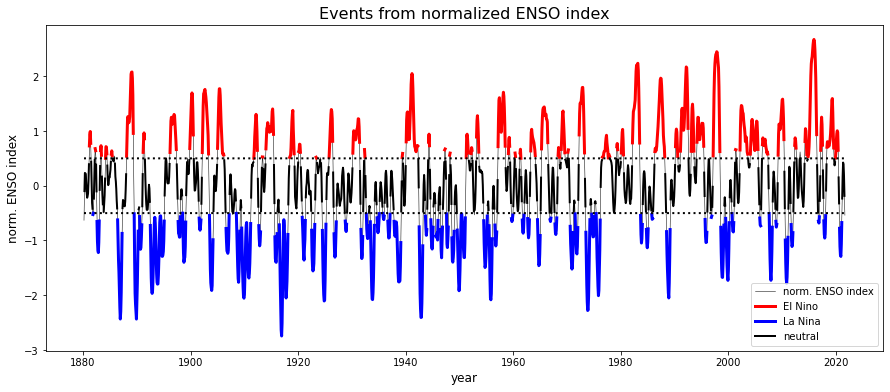

In [13]:
## Another way of highlighting distinct events:

# Mask events for plotting them in different colors
ENSO_ElNino = np.ma.masked_where(ENSO_index_norm.values < 0.5, ENSO_index_norm.values)
ENSO_LaNina = np.ma.masked_where(ENSO_index_norm.values > -0.5, ENSO_index_norm.values)
ENSO_neutral = np.ma.masked_where((ENSO_index_norm.values >= 0.5) | (ENSO_index_norm.values <= -0.5), ENSO_index_norm.values)

# Focus on normalized ENSO index: Highlight events.
# > 0.5: EL Nino, < -0.5: La Nina, else: 'neutral'
fig, axes = plt.subplots(1, 1, figsize=(15,6))
axes.plot(ENSO_index_norm.time, ENSO_index_norm, label='norm. ENSO index', color='black', linewidth=0.5)
axes.plot(ENSO_index_norm.time, ENSO_ElNino, label='El Nino', color='red', linewidth=3)
axes.plot(ENSO_index_norm.time, ENSO_LaNina, label='La Nina', color='blue', linewidth=3)
axes.plot(ENSO_index_norm.time, ENSO_neutral, label='neutral', color='black', linewidth=2)

axes.set_xlabel("year", fontsize=12)
axes.set_ylabel("norm. ENSO index", fontsize=12)
axes.set_title("Events from normalized ENSO index", fontsize=16)
axes.legend()

# Add horizontal lines
axes.plot(ENSO_index_norm.time,0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)
axes.plot(ENSO_index_norm.time,-0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)

plt.show

In [14]:
### Set some of the parameters up-front for splitting timeseries:

## Verbosity:
verbose = True

## Parameters for decomposing and splitting timeseries:
input_length = 10 # Split input series into samples of specified input length.
target_length = 1 # Define target length.
scaled_YN = False # If True: Scale input series with min/max scaling, where min/max are taken only from train data!
scale_to = 'zero_one' # If scaling is desired, choose interval to scale to: 'zero_one' --> [0,1] or 'one_one' --> [-1,1]

In [15]:
# Split normalized ENSO index to train/val input/target:
train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                    input_length=input_length,
                                                                                    target_length=target_length,
                                                                                    time_lag=0, 
                                                                                    train_val_split=0.8,
                                                                                    val_samples_from='end',
                                                                                    abs_to_rel_YN=False,
                                                                                    binary_YN=False,
                                                                                    scaled_YN=scaled_YN,
                                                                                    scale_to=scale_to,
                                                                                    verbose=verbose)

raw data shape:  (1699,)
train_input shape:  (1351, 10, 1)
val_input shape:  (338, 10, 1)
train_target shape:  (1351, 1)
val_target shape:  (338, 1)
train_min:  0
train_max:  0


In [16]:
### Try to model normalized ENSO index with base ESN. Define parameters for ESN model upfront

n_layers = 1 # Number of ESN layers in the model.
n_res = 100 # Number of reservoir units.
W_in_lim = 1.0 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.01 # Leak rate used in transition function of reservoir states.
activation = 'sigmoid' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.9 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
sparsity = 0.2 # Sparsity of reservoir weight matrix.
n_features = 1 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4

In [17]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers, n_res=n_res,
                            W_in_lim=W_in_lim, leak_rate=leak_rate, activation=activation, spec_radius=spec_radius, sparsity=sparsity,
                            verbose=verbose)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpwx4ct89b.py, line 20)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpwx4ct89b.py, line 20)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
esn (ESN)                    ((None, 10, 100), (None,  10300     
___________________________________________________

2022-03-04 07:42:05.956628: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:693: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:732: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sha

2022-03-04 07:42:07.579698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)



shape of train input (samples, timesteps, input features):  (1351, 10, 1)
shape of model output X_T (samples, n_res):  (1351, 100)

W_out shape:  (100, 1)
b_out shape:  (1,)

Final reservoir states in augmented notation, shape:  (1351, 101)

train_target shape (samples, output features):  (1351, 1)
W_out_prime shape:  (101, 1)

trained b_out: 
 [604747.26876285]


/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:769: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


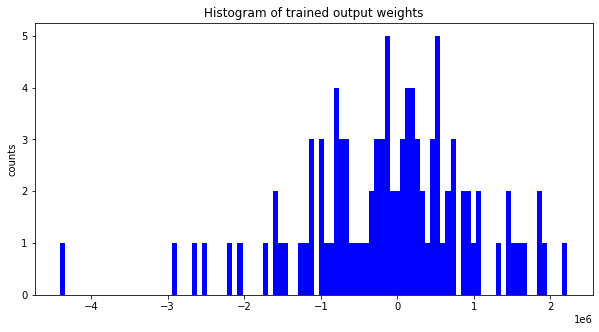

In [18]:
# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


shape of val input (samples, timesteps, features):  (338, 10, 1)
shape of train input (samples, timesteps, features):  (1351, 10, 1)

shape of model predictions on validation input (samples, 1):  (338, 1)
shape of val targets (samples, 1):  (338, 1)

train_mae:  0.1366
val_mae:  0.2235

train_mse:  0.0294
val_mse:  0.1797


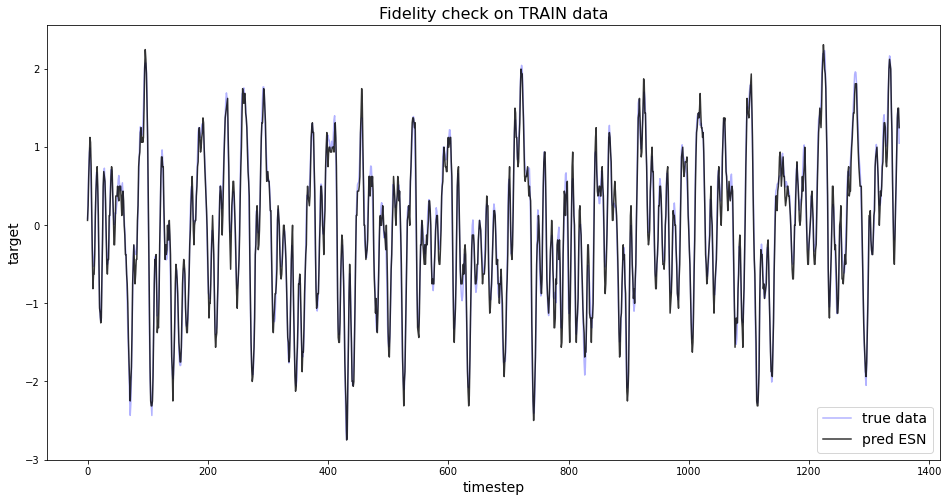

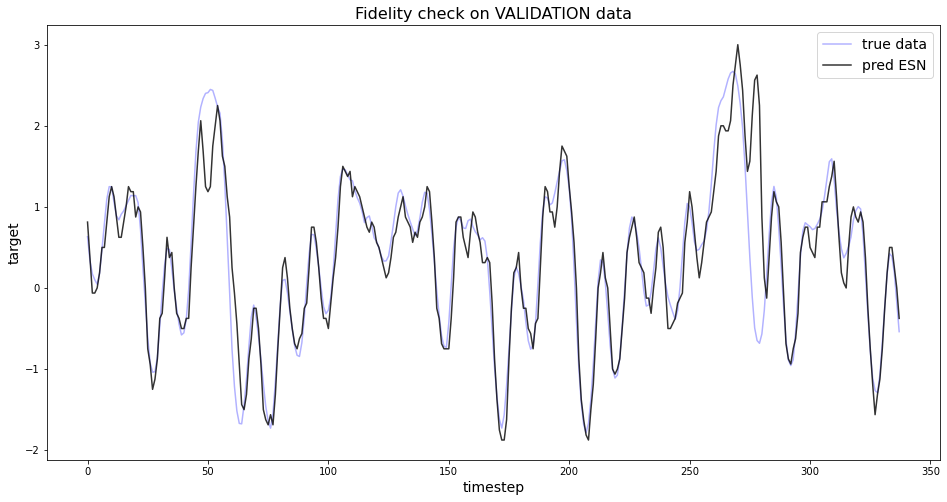

In [19]:
# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                       train_target, val_target,
                                                                       verbose=verbose)

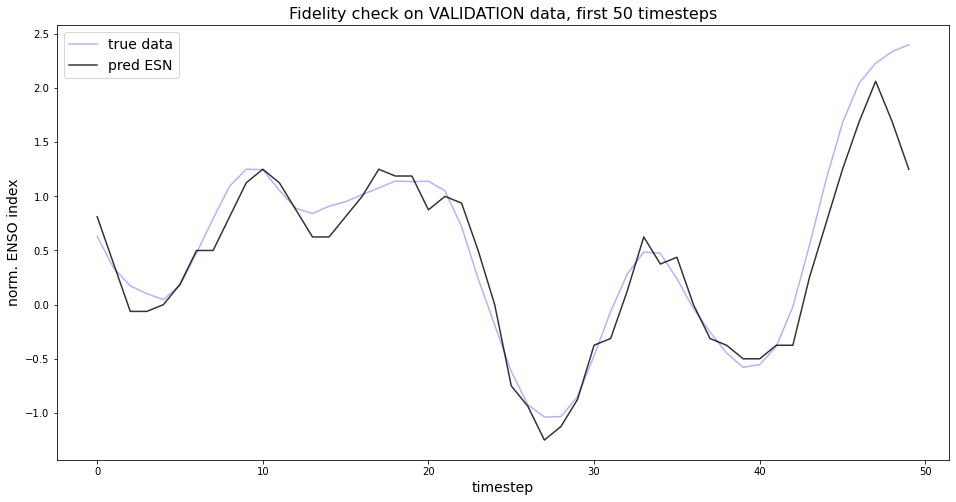

In [20]:
# Fidelity check: Plot val_pred vs. val_targets, but only the first 50 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:50])),val_target[:50],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred[:50])),val_pred[:50],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('norm. ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [21]:
# Check accuracy: How often is the correct label predicted?
# Get number of events: Absolute and realtive to ALL events

print("\nnormalmized ENSO index")
print("======================")

print("\nTOTAL number of timesteps: ", len(ENSO_index_norm))
print("number of EL Nino events: ", np.sum(ENSO_index_norm.values>0.5))
print("number of La Nina events: ", np.sum(ENSO_index_norm.values<-0.5))
print("number of neutral events: ", np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)))

print("\nrel. amount of EL Nino events: ", np.round(np.sum(ENSO_index_norm.values>0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of La Nina events: ", np.round(np.sum(ENSO_index_norm.values<-0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of neutral events: ", np.round(np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)) / len(ENSO_index_norm)*100,1), "%")




normalmized ENSO index

TOTAL number of timesteps:  1699
number of EL Nino events:  549
number of La Nina events:  501
number of neutral events:  649

rel. amount of EL Nino events:  32.3 %
rel. amount of La Nina events:  29.5 %
rel. amount of neutral events:  38.2 %


In [22]:
# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum(((val_pred>0.5)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina = sum(((val_pred<-0.5)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
val_acc_neutral = sum((((val_pred>=-0.5) & (val_pred<=0.5)) == ((val_target>=-0.5) & (val_target<=0.5))) &
                       ((val_target>=-0.5) & (val_target<=0.5))) / sum(((val_target>=-0.5) & (val_target<=0.5)))

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum(((train_pred>0.5)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina = sum(((train_pred<-0.5)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))
train_acc_neutral = sum((((train_pred>=-0.5) & (train_pred<=0.5)) == ((train_target>=-0.5) & (train_target<=0.5))) &
                       ((train_target>=-0.5) & (train_target<=0.5))) / sum(((train_target>=-0.5) & (train_target<=0.5)))

In [23]:
# Get accuracy for target_length=1
# Note: Accurace prediction means having a certain event (e.g. El Nino) and correctly predicting 
#       to have that same event.
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))


Validation accuracy:
El Nino:  0.9
La Nina:  0.8
neutral:  0.89

Train accuracy:
El Nino:  0.85
La Nina:  0.91
neutral:  0.91


In [165]:
# target_length=3
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))


Validation accuracy:
El Nino:  0.65
La Nina:  0.59
neutral:  0.79

Train accuracy:
El Nino:  0.74
La Nina:  0.79
neutral:  0.79


In [185]:
# target_length=6
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))


Validation accuracy:
El Nino:  0.44
La Nina:  0.47
neutral:  0.66

Train accuracy:
El Nino:  0.5
La Nina:  0.56
neutral:  0.67


In [127]:
## Try multistep prediction with a sequence of one-step predictions with target_length=1 in free-float modus:
## Feed prediction as new input for next step's prediction, hence no "teacher-forcing".
## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)

# Set number of free-float timesteps:
n_steps = 6

# Copy original val_input, not to "destroy" it
val_input_temp = np.copy(val_input)

# Loop over desired number of free-float timesteps:
for step in range(n_steps):
    
    # Get prediction for current timestep
    val_pred = model.predict(val_input_temp)
    
    # If first timestep, initialize storage for prediction of ALL timesteps (val_samples, n_steps)
    if step == 0:
        val_pred_all = np.copy(val_pred)
    
    else:
        val_pred_all = np.concatenate([val_pred_all, val_pred], axis=-1)

    ## Create inputs for second timestep from two ingredients:
    # Take all but the first input timesteps from previous input samples:
    temp1 = np.copy(val_input[:,1:,0:1])

    # Reshape predictions from previous timestep:
    temp2 = np.reshape(val_pred,(val_pred.shape[0], 1, 1))

    # Concatenate both ingredients to create input for next timestep:
    val_input_temp = np.concatenate([temp1, temp2], axis=1)

print("shape of val_pred_all (samples, n_steps): ", val_pred_all.shape)


shape of val input (samples, timesteps, features):  (338, 10, 1)
shape of val_pred_all (samples, n_steps):  (338, 6)


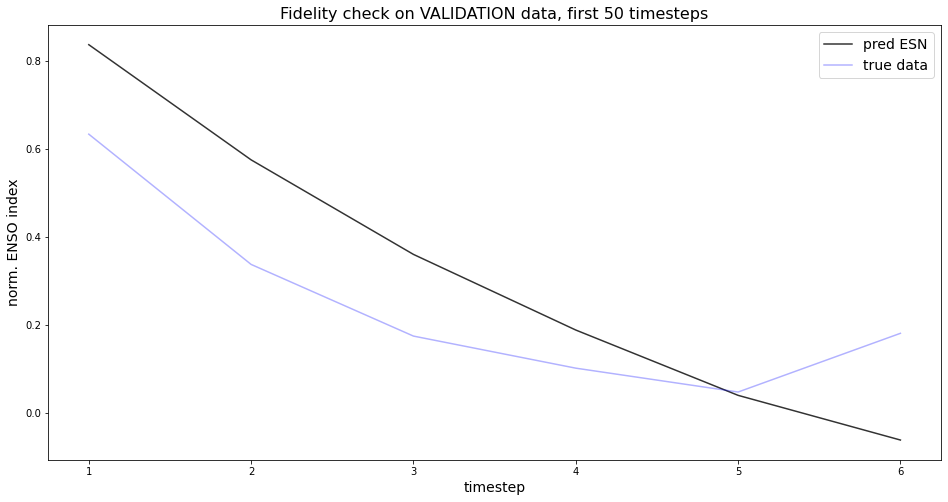

In [128]:
# Fidelity check: Plot free-float predictions vs. true validation targets

# sample
i = 0

plt.figure(figsize=(16,8))
plt.plot(range(1,n_steps+1),val_pred_all[i],'k',label="pred ESN", alpha=0.8)
plt.plot(range(1,n_steps+1),val_target[i:i+n_steps,0],'b',label="true data", alpha=0.3)
plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('norm. ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

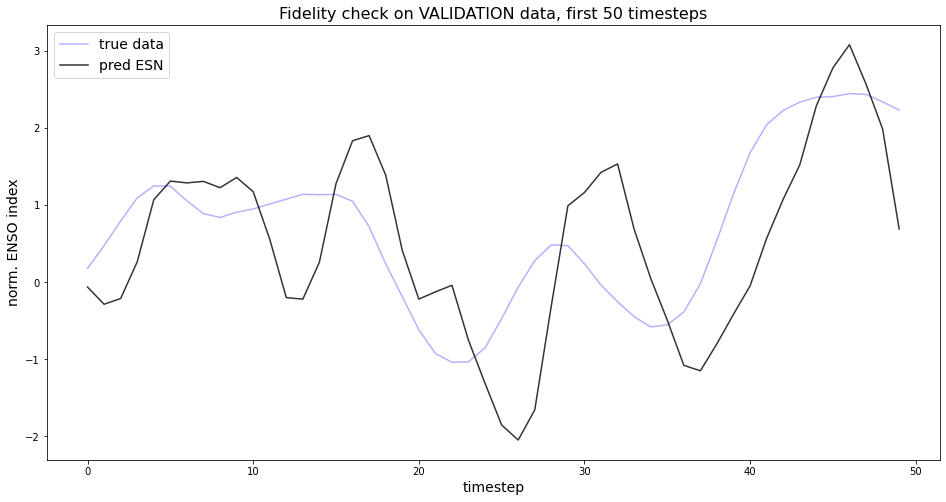

In [124]:
# look at timestep j
j = 5

# Fidelity check: Plot val_pred vs. val_targets, but only the first 50 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[j:50+j])),val_target[j:50+j],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred_all[:50,j])),val_pred_all[:50,j],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('norm. ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Optimizing (Hyper-)parameters using Gradient Descent

So far we have implemented functionality to set up ESN models, train output weights and bias, get model predictions and evaluate model performance.

We are able to apply ESN methodology to a well-known climate problem: El Nino Southern Oscillation (ENSO).

Now we aim to optimize (hyper-)parameters for a base ESN model with just *one* reservoir. A classic approach would be gridsearch optimization. To be able to visualize gridsearch results in heatmaps, one is limited to simultaneously optimize only *two* parameters. In addition to that, the *whole* parameter space is often too large to try *all* possible parameter combinations.

Inspired by stochastic gradient descent - used in training artificial neural networks - we will try to use some kind of gradient descent algorithm to simultaneously optimize *all* desired (hyper-)parameters.

We work with normalized ENSO index, unscaled and with fixed target_length = 1, number of input features reads n_features = 1. As mentioned, we start with optimizing parameters for a base ESN, hence n_layers = 1. Here is an overview of (hyper-)parameters, we aim to optimize in a first attempt:

- input_length: Number of timesteps per input sample.
- n_res: Number of reservoir units.
- W_in_lim: Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
- leak_rate: Leak rate used in transition function of reservoir states.
- spec_radius: Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
- sparsity: Sparsity of reservoir weight matrix.

As activation function to be used in calculating reservoir state transition we start with 'sigmoid', and repeat optimization for 'tanh'.

#### Outline of gradient descent algorithm

1. Set range for each parameter (parameter_min / _max): Optimization is only performed within chosen range.
2. Set initial parameter values within specified range (parameter_base).
3. Set step size for each parameter used over the whole optimization process (parameter_step).
4. Set n_iterations, as maximal number of optimization iterations.
5. Set n_runs, defining how many runs we average over in each iteration, to achieve stable metrics and gradients.
6. Start iterating:

a. Start runs: base parameter setting

- split_data according to chosen input_length to get train and validation inputs and targets.
- setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
- trainESN to train output weights and bias.
- predESN to get metrics [mae, mse] on train and validation data.
- Get base_train_mae and _mse as average over n_runs.
- Store base_train_mae / _mse and base_val_mae / _mse and current parameter setting.

b. Start runs: modify each parameter individually (up and down)

- split_data, setESN, trainESN, predESN
- Get param_up_train_mae / _mse and param_down_train_mae / _mse as average over n_runs on train data.

c. Estimate gradients for each parameter, when modifying parameter up / down, focus on **train mse**

- Calculate differences: param_up_grad = param_up_train_mse - base_train_mse, param_down_grad = param_down_train_mse - base_train_mse

d. Modify parameter setting according to gradients

- Modify each parameter according to specified step size in the direction of lowest gradient.
- Leave parameter unchanged, if both gradients (_up and _down) are positive, hence modification would lower model performance.
- Also leave parameter unchanged, if modification would lead parameter out of specified range.

e. Early stop iteration process

- Break out of iteration, when all parameters are left unchanged.

7. Plot results:

- Plot mae and mse over iterations for train and validation data.
- Plot parameters over iterations.


In [61]:
### Set parameters for optimization:

## Verbosity: Mute interim outputs from split_data, setESN, trainESN and predESN
verbose = False

## Parameters for splitting timeseries and setting up ESN model, that are kept UNCHANGED in optimization:
target_length = 3 # Define target length.
scaled_YN = False # If True: Scale input series with min/max scaling, where min/max are taken only from train data!
scale_to = 'zero_one' # If scaling is desired, choose interval to scale to: 'zero_one' --> [0,1] or 'one_one' --> [-1,1]
n_layers = 1 # Number of ESN layers in the model.
n_features = 1 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4
activation = 'sigmoid' # Desired activation function to be used in calculating reservoir state transition.

## Parameters to optimized: Initial values, range for optimization (_min / _max) and step size (_step)

# Split input series into samples of specified input length.
input_length_base = 10 
input_length_min = 5
input_length_max = 20
input_length_step = 1

# Number of reservoir units.
n_res_base = 100 
n_res_min = 60
n_res_max = 300
n_res_step = 20

# Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
W_in_lim_base = 0.5 
W_in_lim_min = 0.1
W_in_lim_max = 1
W_in_lim_step = 0.1

# Leak rate used in transition function of reservoir states.
leak_rate_base = 0.1 
leak_rate_min = 0.01
leak_rate_max = 0.2
leak_rate_step = 0.01

# Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
spec_radius_base = 0.8 
spec_radius_min = 0.1
spec_radius_max = 1.0
spec_radius_step = 0.1

# Sparsity of reservoir weight matrix.
sparsity_base = 0.2 
sparsity_min = 0.1
sparsity_max = 0.4
sparsity_step = 0.05

## Parameters for optimization process:

# (max.) number of iterations
n_iterations = 20

# Number of runs we average over in each iteration, to achieve stable metrics and gradients.
n_runs = 5

In [ ]:
### Optimization of (hyper-)parameters for base ESN

## Initialize storage for mae and mse over iterations for train and validation data:
train_mae_all = []
train_mse_all = []
val_mae_all = []
val_mse_all = []

## Initialize storage for parameters over iterations: Store initial parameter setting.
input_length_all = [input_length_base]
n_res_all = [n_res_base]
W_in_lim_all = [W_in_lim_base]
leak_rate_all = [leak_rate_base]
spec_radius_all = [spec_radius_base]
sparsity_all = [sparsity_base]

## Loop over (max.) number of iterations:
for iteration in range(n_iterations):
    
    # Print status:
    print("\niteration :", iteration+1, "from ", n_iterations)
    
    ## Loop over desired number of runs per iteration, to get metrics on current base setting:
    
    # Initialize storage for base_mae / _mse on train / validation data:
    base_train_mae = 0
    base_train_mse = 0
    base_val_mae = 0
    base_val_mse = 0
    
    # split_data according to chosen input_length to get train and validation inputs and targets.
    train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length_base,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)

    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        base_train_mae += train_mae
        base_train_mse += train_mse
        base_val_mae += val_mae
        base_val_mse += val_mse
        
    # Store averaged base mae / mse on train / validation data:
    base_train_mae = base_train_mae / n_runs
    base_train_mse = base_train_mse / n_runs
    base_val_mae = base_val_mae / n_runs
    base_val_mse = base_val_mse / n_runs

    train_mae_all.append(base_train_mae)
    train_mse_all.append(base_train_mse)
    val_mae_all.append(base_val_mae)
    val_mse_all.append(base_val_mse)
    
    
    ## Change only input_length UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if input_length_base + input_length_step <= input_length_max:
        input_length = input_length_base + input_length_step
    else:
        input_length = input_length_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    input_length_UP_train_mae = 0
    input_length_UP_train_mse = 0
    input_length_UP_val_mae = 0
    input_length_UP_val_mse = 0
    
    # split_data according to chosen input_length to get train and validation inputs and targets.
    train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)
        
    for run in range(n_runs):

        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)        

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        input_length_UP_train_mae += train_mae
        input_length_UP_train_mse += train_mse
        input_length_UP_val_mae += val_mae
        input_length_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    input_length_UP_train_mae = input_length_UP_train_mae / n_runs
    input_length_UP_train_mse = input_length_UP_train_mse / n_runs
    input_length_UP_val_mae = input_length_UP_val_mae / n_runs
    input_length_UP_val_mse = input_length_UP_val_mse / n_runs
    

    ## Change only input_length DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if input_length_base - input_length_step >= input_length_min:
        input_length = input_length_base - input_length_step
    else:
        input_length = input_length_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    input_length_DOWN_train_mae = 0
    input_length_DOWN_train_mse = 0
    input_length_DOWN_val_mae = 0
    input_length_DOWN_val_mse = 0
    
    # split_data according to chosen input_length to get train and validation inputs and targets.
    train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)

    for run in range(n_runs):

        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        input_length_DOWN_train_mae += train_mae
        input_length_DOWN_train_mse += train_mse
        input_length_DOWN_val_mae += val_mae
        input_length_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    input_length_DOWN_train_mae = input_length_DOWN_train_mae / n_runs
    input_length_DOWN_train_mse = input_length_DOWN_train_mse / n_runs
    input_length_DOWN_val_mae = input_length_DOWN_val_mae / n_runs
    input_length_DOWN_val_mse = input_length_DOWN_val_mse / n_runs
       
       
    ## Next change further parameters UP/DOWN, but keep input data fixed, so split data upfront.
    ## Use current iteration's base input_length!
    
    # split_data according to chosen input_length to get train and validation inputs and targets.
    train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length_base,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)

    
    ## Change only n_res UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if n_res_base + n_res_step <= n_res_max:
        n_res = n_res_base + n_res_step
    else:
        n_res = n_res_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    n_res_UP_train_mae = 0
    n_res_UP_train_mse = 0
    n_res_UP_val_mae = 0
    n_res_UP_val_mse = 0
    
    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        n_res_UP_train_mae += train_mae
        n_res_UP_train_mse += train_mse
        n_res_UP_val_mae += val_mae
        n_res_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    n_res_UP_train_mae = n_res_UP_train_mae / n_runs
    n_res_UP_train_mse = n_res_UP_train_mse / n_runs
    n_res_UP_val_mae = n_res_UP_val_mae / n_runs
    n_res_UP_val_mse = n_res_UP_val_mse / n_runs
    

    ## Change only n_res DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if n_res_base - n_res_step >= n_res_min:
        n_res = n_res_base - n_res_step
    else:
        n_res = n_res_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    n_res_DOWN_train_mae = 0
    n_res_DOWN_train_mse = 0
    n_res_DOWN_val_mae = 0
    n_res_DOWN_val_mse = 0
    
    for run in range(n_runs):
        
       # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        n_res_DOWN_train_mae += train_mae
        n_res_DOWN_train_mse += train_mse
        n_res_DOWN_val_mae += val_mae
        n_res_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    n_res_DOWN_train_mae = n_res_DOWN_train_mae / n_runs
    n_res_DOWN_train_mse = n_res_DOWN_train_mse / n_runs
    n_res_DOWN_val_mae = n_res_DOWN_val_mae / n_runs
    n_res_DOWN_val_mse = n_res_DOWN_val_mse / n_runs
    
    
    ## Change only W_in_lim UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if W_in_lim_base + W_in_lim_step <= W_in_lim_max:
        W_in_lim = W_in_lim_base + W_in_lim_step
    else:
        W_in_lim = W_in_lim_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    W_in_lim_UP_train_mae = 0
    W_in_lim_UP_train_mse = 0
    W_in_lim_UP_val_mae = 0
    W_in_lim_UP_val_mse = 0
    
    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        W_in_lim_UP_train_mae += train_mae
        W_in_lim_UP_train_mse += train_mse
        W_in_lim_UP_val_mae += val_mae
        W_in_lim_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    W_in_lim_UP_train_mae = W_in_lim_UP_train_mae / n_runs
    W_in_lim_UP_train_mse = W_in_lim_UP_train_mse / n_runs
    W_in_lim_UP_val_mae = W_in_lim_UP_val_mae / n_runs
    W_in_lim_UP_val_mse = W_in_lim_UP_val_mse / n_runs
    

    ## Change only W_in_lim DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if W_in_lim_base - W_in_lim_step >= W_in_lim_min:
        W_in_lim = W_in_lim_base - W_in_lim_step
    else:
        W_in_lim_ = W_in_lim_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    W_in_lim_DOWN_train_mae = 0
    W_in_lim_DOWN_train_mse = 0
    W_in_lim_DOWN_val_mae = 0
    W_in_lim_DOWN_val_mse = 0
    
    for run in range(n_runs):
        
       # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        W_in_lim_DOWN_train_mae += train_mae
        W_in_lim_DOWN_train_mse += train_mse
        W_in_lim_DOWN_val_mae += val_mae
        W_in_lim_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    W_in_lim_DOWN_train_mae = W_in_lim_DOWN_train_mae / n_runs
    W_in_lim_DOWN_train_mse = W_in_lim_DOWN_train_mse / n_runs
    W_in_lim_DOWN_val_mae = W_in_lim_DOWN_val_mae / n_runs
    W_in_lim_DOWN_val_mse = W_in_lim_DOWN_val_mse / n_runs
    
    
    ## Change only leak_rate UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if leak_rate_base + leak_rate_step <= leak_rate_max:
        leak_rate = leak_rate_base + leak_rate_step
    else:
        leak_rate = leak_rate_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    leak_rate_UP_train_mae = 0
    leak_rate_UP_train_mse = 0
    leak_rate_UP_val_mae = 0
    leak_rate_UP_val_mse = 0
    
    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        leak_rate_UP_train_mae += train_mae
        leak_rate_UP_train_mse += train_mse
        leak_rate_UP_val_mae += val_mae
        leak_rate_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    leak_rate_UP_train_mae = leak_rate_UP_train_mae / n_runs
    leak_rate_UP_train_mse = leak_rate_UP_train_mse / n_runs
    leak_rate_UP_val_mae = leak_rate_UP_val_mae / n_runs
    leak_rate_UP_val_mse = leak_rate_UP_val_mse / n_runs
    

    ## Change only leak_rate DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if leak_rate_base - leak_rate_step >= leak_rate_min:
        leak_rate = leak_rate_base - leak_rate_step
    else:
        leak_rate = leak_rate_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    leak_rate_DOWN_train_mae = 0
    leak_rate_DOWN_train_mse = 0
    leak_rate_DOWN_val_mae = 0
    leak_rate_DOWN_val_mse = 0
    
    for run in range(n_runs):
        
       # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        leak_rate_DOWN_train_mae += train_mae
        leak_rate_DOWN_train_mse += train_mse
        leak_rate_DOWN_val_mae += val_mae
        leak_rate_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    leak_rate_DOWN_train_mae = leak_rate_DOWN_train_mae / n_runs
    leak_rate_DOWN_train_mse = leak_rate_DOWN_train_mse / n_runs
    leak_rate_DOWN_val_mae = leak_rate_DOWN_val_mae / n_runs
    leak_rate_DOWN_val_mse = leak_rate_DOWN_val_mse / n_runs
    
    
    ## Change only spec_radius UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if spec_radius_base + spec_radius_step <= spec_radius_max:
        spec_radius = spec_radius_base + spec_radius_step
    else:
        spec_radius = spec_radius_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    spec_radius_UP_train_mae = 0
    spec_radius_UP_train_mse = 0
    spec_radius_UP_val_mae = 0
    spec_radius_UP_val_mse = 0
    
    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        spec_radius_UP_train_mae += train_mae
        spec_radius_UP_train_mse += train_mse
        spec_radius_UP_val_mae += val_mae
        spec_radius_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    spec_radius_UP_train_mae = spec_radius_UP_train_mae / n_runs
    spec_radius_UP_train_mse = spec_radius_UP_train_mse / n_runs
    spec_radius_UP_val_mae = spec_radius_UP_val_mae / n_runs
    spec_radius_UP_val_mse = spec_radius_UP_val_mse / n_runs
    

    ## Change only spec_radius DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if spec_radius_base - spec_radius_step >= spec_radius_min:
        spec_radius = spec_radius_base - spec_radius_step
    else:
        spec_radius = spec_radius_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    spec_radius_DOWN_train_mae = 0
    spec_radius_DOWN_train_mse = 0
    spec_radius_DOWN_val_mae = 0
    spec_radius_DOWN_val_mse = 0
    
    for run in range(n_runs):
        
       # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius, sparsity=sparsity_base,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        spec_radius_DOWN_train_mae += train_mae
        spec_radius_DOWN_train_mse += train_mse
        spec_radius_DOWN_val_mae += val_mae
        spec_radius_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    spec_radius_DOWN_train_mae = spec_radius_DOWN_train_mae / n_runs
    spec_radius_DOWN_train_mse = spec_radius_DOWN_train_mse / n_runs
    spec_radius_DOWN_val_mae = spec_radius_DOWN_val_mae / n_runs
    spec_radius_DOWN_val_mse = spec_radius_DOWN_val_mse / n_runs


    ## Change only sparsity UP: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if sparsity_base + sparsity_step <= sparsity_max:
        sparsity = sparsity_base + sparsity_step
    else:
        sparsity = sparsity_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    sparsity_UP_train_mae = 0
    sparsity_UP_train_mse = 0
    sparsity_UP_val_mae = 0
    sparsity_UP_val_mse = 0
    
    for run in range(n_runs):
        
        # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        sparsity_UP_train_mae += train_mae
        sparsity_UP_train_mse += train_mse
        sparsity_UP_val_mae += val_mae
        sparsity_UP_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    sparsity_UP_train_mae = sparsity_UP_train_mae / n_runs
    sparsity_UP_train_mse = sparsity_UP_train_mse / n_runs
    sparsity_UP_val_mae = sparsity_UP_val_mae / n_runs
    sparsity_UP_val_mse = sparsity_UP_val_mse / n_runs
    

    ## Change only sparsity DOWN: Loop over desired number of runs per iteration, to get metrics:
    
    # Check if raised parameter is still inside specified parameter range:
    if sparsity_base - sparsity_step >= sparsity_min:
        sparsity = sparsity_base - sparsity_step
    else:
        sparsity = sparsity_base
    
    # Initialize storage for _mae / _mse on train / validation data:
    sparsity_DOWN_train_mae = 0
    sparsity_DOWN_train_mse = 0
    sparsity_DOWN_val_mae = 0
    sparsity_DOWN_val_mse = 0
    
    for run in range(n_runs):
        
       # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
        model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                    n_res=n_res_base, W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                    activation=activation, spec_radius=spec_radius_base, sparsity=sparsity,
                                    verbose=verbose)

        # trainESN to train output weights and bias.
        model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


        # predESN to get metrics [mae, mse] on train and validation data.
        train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                               train_target, val_target,
                                                                               verbose=verbose)
        
        # Store current run's mae / mse on train / validation data:
        sparsity_DOWN_train_mae += train_mae
        sparsity_DOWN_train_mse += train_mse
        sparsity_DOWN_val_mae += val_mae
        sparsity_DOWN_val_mse += val_mse

    # Get averaged (over n_runs) mae / mse on train / validation data:
    sparsity_DOWN_train_mae = sparsity_DOWN_train_mae / n_runs
    sparsity_DOWN_train_mse = sparsity_DOWN_train_mse / n_runs
    sparsity_DOWN_val_mae = sparsity_DOWN_val_mae / n_runs
    sparsity_DOWN_val_mse = sparsity_DOWN_val_mse / n_runs
    
    
    
    ## Estimate gradients for each parameter, when modifying parameter up / down, focus on train mse
    
    # Calculate differences: param_up_grad = param_up_train_mse - base_train_mse, 
    #                        param_down_grad = param_down_train_mse - base_train_mse

    # input_length
    input_length_UP_grad = input_length_UP_train_mse - base_train_mse
    input_length_DOWN_grad = input_length_DOWN_train_mse - base_train_mse
    
    # n_res
    n_res_UP_grad = n_res_UP_train_mse - base_train_mse
    n_res_DOWN_grad = n_res_DOWN_train_mse - base_train_mse
    
    # W_in_lim
    W_in_lim_UP_grad = W_in_lim_UP_train_mse - base_train_mse
    W_in_lim_DOWN_grad = W_in_lim_DOWN_train_mse - base_train_mse
    
    # leak_rate
    leak_rate_UP_grad = leak_rate_UP_train_mse - base_train_mse
    leak_rate_DOWN_grad = leak_rate_DOWN_train_mse - base_train_mse
    
    # spec_radius
    spec_radius_UP_grad = spec_radius_UP_train_mse - base_train_mse
    spec_radius_DOWN_grad = spec_radius_DOWN_train_mse - base_train_mse
    
    # sparsity
    sparsity_UP_grad = sparsity_UP_train_mse - base_train_mse
    sparsity_DOWN_grad = sparsity_DOWN_train_mse - base_train_mse

    
    ## Modify parameter setting according to gradients:
    
    # Modify each parameter according to specified step size in the direction of lowest gradient.
    # Leave parameter unchanged, if both gradients (_up and _down) are positive, 
    # hence modification would lower model performance.
    # Also leave parameter unchanged, if modification would lead parameter out of specified range.

    # input_length
    if (input_length_UP_grad < input_length_DOWN_grad) & (input_length_UP_grad < 0):
        input_length_base = input_length_base + input_length_step
    elif (input_length_UP_grad >= input_length_DOWN_grad) & (input_length_DOWN_grad < 0):
        input_length_base = input_length_base - input_length_step
        
    # n_res
    if (n_res_UP_grad < n_res_DOWN_grad) & (n_res_UP_grad < 0):
        n_res_base = n_res_base + n_res_step
    elif (n_res_UP_grad >= n_res_DOWN_grad) & (n_res_DOWN_grad < 0):
        n_res_base = n_res_base - n_res_step

    # W_in_lim
    if (W_in_lim_UP_grad < W_in_lim_DOWN_grad) & (W_in_lim_UP_grad < 0):
        W_in_lim_base = W_in_lim_base + W_in_lim_step
    elif (W_in_lim_UP_grad >= W_in_lim_DOWN_grad) & (W_in_lim_DOWN_grad < 0):
        W_in_lim_base = W_in_lim_base - W_in_lim_step
        
     # leak_rate
    if (leak_rate_UP_grad < leak_rate_DOWN_grad) & (leak_rate_UP_grad < 0):
        leak_rate_base = leak_rate_base + leak_rate_step
    elif (leak_rate_UP_grad >= leak_rate_DOWN_grad) & (leak_rate_DOWN_grad < 0):
        leak_rate_base = leak_rate_base - leak_rate_step
        
    # spec_radius
    if (spec_radius_UP_grad < spec_radius_DOWN_grad) & (spec_radius_UP_grad < 0):
        spec_radius_base = spec_radius_base + spec_radius_step
    elif (spec_radius_UP_grad >= spec_radius_DOWN_grad) & (spec_radius_DOWN_grad < 0):
        spec_radius_base = spec_radius_base - spec_radius_step

    # sparsity
    if (sparsity_UP_grad < sparsity_DOWN_grad) & (sparsity_UP_grad < 0):
        sparsity_base = sparsity_base + sparsity_step
    elif (sparsity_UP_grad >= sparsity_DOWN_grad) & (sparsity_DOWN_grad < 0):
        sparsity_base = sparsity_base - sparsity_step
        
    ## Store modified parameter setting.
    input_length_all.append(input_length_base)
    n_res_all.append(n_res_base)
    W_in_lim_all.append(W_in_lim_base)
    leak_rate_all.append(leak_rate_base)
    spec_radius_all.append(spec_radius_base)
    sparsity_all.append(sparsity_base)
    
    ##########(... only implemented UP/DOWN adjustment for input_length, add other parameters!!! ...)

## After iterations are done, need final model performance taking final parameter modifications into account.
## Loop over desired number of runs per iteration, to get metrics on current base setting:
    
# Initialize storage for base_mae / _mse on train / validation data:
base_train_mae = 0
base_train_mse = 0
base_val_mae = 0
base_val_mse = 0
    
for run in range(n_runs):

    # split_data according to chosen input_length to get train and validation inputs and targets.
    train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                input_length=input_length_base,
                                                                                target_length=target_length,
                                                                                time_lag=0, 
                                                                                train_val_split=0.8,
                                                                                val_samples_from='end',
                                                                                abs_to_rel_YN=False,
                                                                                binary_YN=False,
                                                                                scaled_YN=scaled_YN,
                                                                                scale_to=scale_to,
                                                                                verbose=verbose)




    # setESN to set up ESN model according to specified ESN parameters and modify reservoir weights.
    model, model_short = setESN(input_length=input_length_base, n_features=n_features, n_layers=n_layers,
                                n_res=n_res_base,W_in_lim=W_in_lim_base, leak_rate=leak_rate_base,
                                activation=activation, spec_radius=spec_radius_base, sparsity=sparsity_base,
                                verbose=verbose)

    # trainESN to train output weights and bias.
    model = trainESN(model, model_short, train_input, train_target, verbose=verbose)


    # predESN to get metrics [mae, mse] on train and validation data.
    train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                           train_target, val_target,
                                                                           verbose=verbose)

    # Store current run's mae / mse on train / validation data:
    base_train_mae += train_mae
    base_train_mse += train_mse
    base_val_mae += val_mae
    base_val_mse += val_mse

# Store averaged base mae / mse on train / validation data:
base_train_mae = base_train_mae / n_runs
base_train_mse = base_train_mse / n_runs
base_val_mae = base_val_mae / n_runs
base_val_mse = base_val_mse / n_runs

train_mae_all.append(base_train_mae)
train_mse_all.append(base_train_mse)
val_mae_all.append(base_val_mae)
val_mse_all.append(base_val_mse)


iteration : 1 from  20


/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:693: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v03.py:769: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



iteration : 2 from  20


In [53]:
train_mse_all

[0.014100000000000001,
 0.010839999999999999,
 0.00988,
 0.009659999999999998,
 0.009179999999999999,
 0.0089,
 0.0089,
 0.009059999999999999,
 0.00938,
 0.009040000000000001,
 0.00816,
 0.00842,
 0.00826,
 0.00808,
 0.00742,
 0.007680000000000001,
 0.0074399999999999996,
 0.007300000000000001,
 0.006959999999999999,
 0.006660000000000001,
 0.00682]

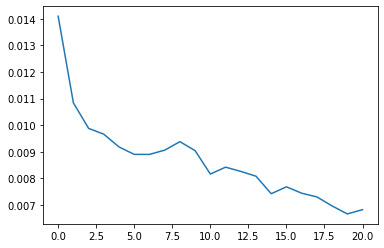

In [42]:
plt.plot(train_mse_all)

In [54]:
val_mse_all

[0.02196,
 0.013600000000000001,
 0.01552,
 0.017220000000000003,
 0.03724,
 0.06517999999999999,
 0.03868,
 0.03678,
 0.04166,
 0.039080000000000004,
 0.05512,
 0.05474,
 0.10185999999999999,
 0.12261999999999999,
 0.07110000000000001,
 0.1784,
 0.10332000000000001,
 0.35184,
 0.15552000000000002,
 0.25304000000000004,
 0.3364]

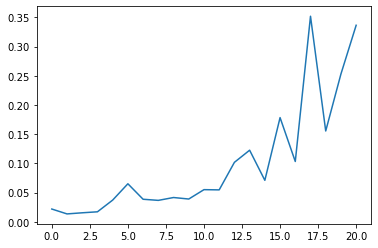

In [43]:
plt.plot(val_mse_all)

In [44]:
# Look at parameter evolution over iterations
input_length_all

[10, 9, 8, 8, 8, 9, 9, 10, 9, 10, 11, 11, 12, 13, 12, 11, 12, 13, 14, 14, 15]

In [45]:
n_res_all

[100,
 80,
 100,
 80,
 100,
 100,
 100,
 100,
 120,
 100,
 120,
 120,
 140,
 140,
 160,
 180,
 200,
 180,
 180,
 200,
 200]

In [46]:
W_in_lim_all

[0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.8999999999999999,
 0.8999999999999999,
 0.8999999999999999,
 0.7999999999999999,
 0.8999999999999999,
 0.7999999999999999,
 0.8999999999999999,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.8999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.8999999999999999,
 0.9999999999999999]

In [47]:
leak_rate_all

[0.1,
 0.11,
 0.12,
 0.12,
 0.13,
 0.14,
 0.15000000000000002,
 0.15000000000000002,
 0.16000000000000003,
 0.15000000000000002,
 0.16000000000000003,
 0.16000000000000003,
 0.17000000000000004,
 0.18000000000000005,
 0.19000000000000006,
 0.18000000000000005,
 0.19000000000000006,
 0.19000000000000006,
 0.20000000000000007,
 0.20000000000000007,
 0.20000000000000007]

In [48]:
spec_radius_all

[0.8,
 0.9,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.1,
 1.2000000000000002,
 1.2000000000000002,
 1.1,
 1.2000000000000002,
 1.2000000000000002,
 1.1,
 1.2000000000000002,
 1.2000000000000002,
 1.3000000000000003,
 1.4000000000000004,
 1.4000000000000004]

In [49]:
sparsity_all

[0.2,
 0.25,
 0.2,
 0.15000000000000002,
 0.15000000000000002,
 0.2,
 0.15000000000000002,
 0.15000000000000002,
 0.15000000000000002,
 0.2,
 0.25,
 0.25,
 0.2,
 0.15000000000000002,
 0.10000000000000002,
 0.05000000000000002,
 0.10000000000000002,
 0.10000000000000002,
 0.15000000000000002,
 0.15000000000000002,
 0.2]

In [59]:
# Get optimal parameters on one sight:
i = 9

print("input_length: ", input_length_all[i])
print("n_res: ", n_res_all[i])
print("W_in_lim: ", np.round(W_in_lim_all[i], 2))
print("leak_rate: ", np.round(leak_rate_all[i], 2))
print("spec_radius: ", spec_radius_all[i])
print("sparsity: ", sparsity_all[i])

print("\ntrain_mse: ", np.round(train_mse_all[i], 4))
print("val_mse: ", np.round(val_mse_all[i], 4))


input_length:  10
n_res:  100
W_in_lim:  0.9
leak_rate:  0.15
spec_radius:  1.1
sparsity:  0.2

train_mse:  0.009
val_mse:  0.0391



shape of val input (samples, timesteps, features):  (337, 15, 1)
shape of train input (samples, timesteps, features):  (1347, 15, 1)

shape of model predictions on validation input (samples, 1):  (337, 1)
shape of val targets (samples, 1):  (337, 1)

train_mae:  0.0644
val_mae:  0.1908

train_mse:  0.0069
val_mse:  0.1909


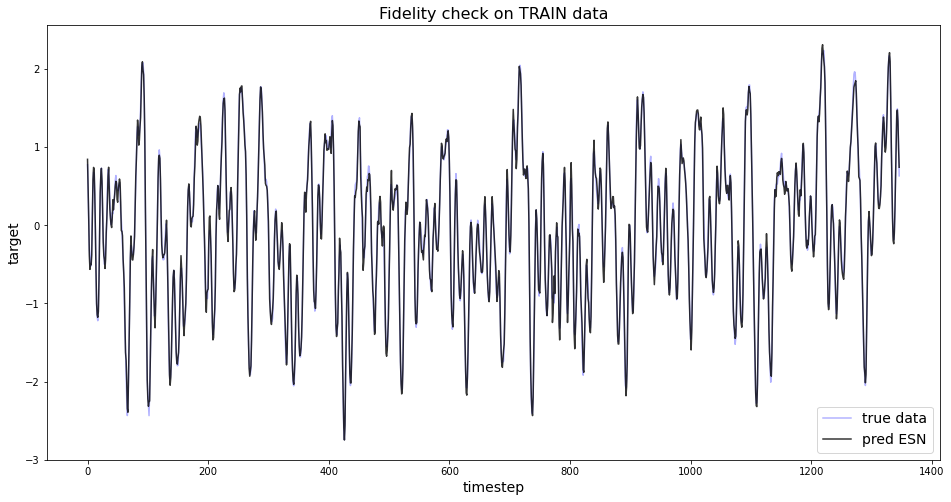

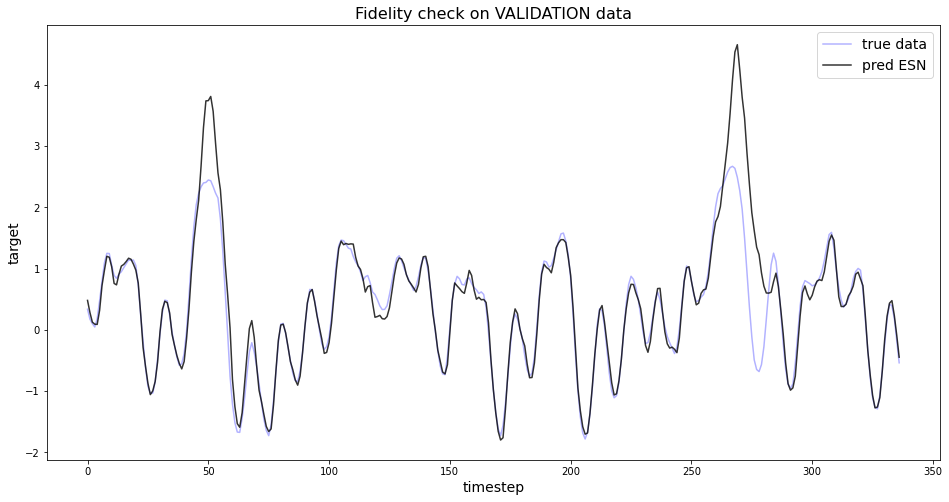

In [50]:
# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                       train_target, val_target,
                                                                       verbose=True)

In [51]:
# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum(((val_pred>0.5)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina = sum(((val_pred<-0.5)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
val_acc_neutral = sum((((val_pred>=-0.5) & (val_pred<=0.5)) == ((val_target>=-0.5) & (val_target<=0.5))) &
                       ((val_target>=-0.5) & (val_target<=0.5))) / sum(((val_target>=-0.5) & (val_target<=0.5)))

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum(((train_pred>0.5)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina = sum(((train_pred<-0.5)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))
train_acc_neutral = sum((((train_pred>=-0.5) & (train_pred<=0.5)) == ((train_target>=-0.5) & (train_target<=0.5))) &
                       ((train_target>=-0.5) & (train_target<=0.5))) / sum(((train_target>=-0.5) & (train_target<=0.5)))

In [52]:
# Get accuracy for target_length=1
# Note: Accurace prediction means having a certain event (e.g. El Nino) and correctly predicting 
#       to have that same event.
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))


Validation accuracy:
El Nino:  0.95
La Nina:  0.9
neutral:  0.9

Train accuracy:
El Nino:  0.96
La Nina:  0.97
neutral:  0.93


### Discussion on Optimizing (hyper-)parameters using Gradient Descent

Implementation appears a bit lengthy, could / should be functionalized. However, optimization with gradient descent seems to work quite fine!

Some optional next steps to keep in mind:

- One could try to extend the optimization algorithm to DeepESN models: Further parameter n_layers.
- Could think of adding some form of *momentum*, like in ADAM optimizer.
- Could implement early-stopping, when all gradients are positiv and no lower mse can be achieved.

So far we have only optimized base ESN on normlized ENSO index with fixed:

- target_length = 1 
- activation = 'sigmoid'
- scaled_YN = False

If we find some high accuracy with this activation and scaling option, we should move on and optimize parameters for increasing target_length = 2, 3, 4, .., 12.

Could also try fine-tuning: Start with already optimized parameter setting and do another optimization run with smaller steps (= lower "learning rate").

#### Is that approach "new" or have others done the same?

First glance at Google revealed that there has been a lot of work on optimizing ESN (hyper-)parameters. Found e.g. [paper](https://arxiv.org/pdf/1903.05071.pdf) "Efficient Optimization of Echo State Networks for Time Series Datasets" using Bayesian optimization. Need to further investigate, if there has been some similar approach like mine in other publications.